In [1]:
import datetime
import pandas as pd
import time
from scipy.stats import linregress
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

#### Task: To compare the risk and return of:
  1. Alpha weighted Portfolio 
  2. Beta Weighted Portfolio
  3. Equiweighted portfolio 
  Consisting of n number of stocks with benchmark i.e NIFTY 50

For this, we will divide our data in groups of calculation period and evaluation period.

Calculation Period, will be used to calculate alpha, beta and volatility of different stocks and based on these parameters we decide how much percent (weight) to invest in which stock.

And Evaluation Period is of the same number of days as the Calculation Period, during which we will calculate the performance of our poortfolio.

In [2]:
##---- here we are considering 3000 days of data
stocks= pd.read_csv('names.csv')
names=[name+'.NS' for name in stocks.Symbol]
names.insert(0,'%5ENSEI')
days=3000        #Number of Trading Days of which we want historical data.
period=63        # Approximate number of trading days in a quater. 
n_stocks=30       #Max Number of Stocks in portfolio.

In [3]:
def get_data(names, days):
    t2=int(time.mktime((datetime.date.today() - datetime.timedelta(1)).timetuple())+19800)
    t1=int(time.mktime((datetime.date.today() - datetime.timedelta(days)).timetuple())+19800)
    df= pd.DataFrame()
    for name in names:
        try:
            url='https://query1.finance.yahoo.com/v7/finance/download/' \
                +name+'?period1='+str(t1)+'&period2='+str(t2)+'&interval=1d&events=history&includeAdjustedClose=true'

            if name!= '%5ENSEI':
                a= pd.read_csv(url)                                                                 ##getting data from url
                a=a.loc[:][['Date','Adj Close']].rename(columns={'Adj Close':name[:-3]})            #Considering only Adjusted close, to consider for dividends and stock splits
                if len(a)> 0.6*days:     ##Ignoring Stocks which are new and have less number of trading days
                    df=df.merge(a, on='Date')
                    #print(name[:-3]+' success')
                else:
                    #pass
                    print(name[:-3]+' small size')
            else:
                a= pd.read_csv(url)
                df=a.loc[:][['Date','Adj Close']].rename(columns={'Adj Close':'NIFTY'})
                #print('NIFTY success')
        
        except Exception as e:
            print(name, e)
    df.Date=pd.to_datetime(df.Date)    
    return df

In [4]:
df=get_data(names,days).dropna(axis=0)
print(len(df))

HDFCLIFE small size
SBILIFE small size
2010


In [5]:
df.reset_index(inplace= True, drop = True)
dates=df.pop('Date')

In [6]:
if len(dates)==len(df):
    print(len(df))


2010


#### 1. Alpha refers to excess returns earned on an investment above the benchmark return.
--- Active portfolio managers seek to generate alpha in diversified portfolios with diversification intended to eliminate unsystematic risk.

#### 2. Beta is a measure of a stock's volatility in relation to the overall market.
---- By definition, the market, such as the Nifty Index, has a beta of 1.0
##### ---High-beta stocks are supposed to be riskier but provide higher return potential; & low-beta stocks pose less risk but also lower returns.

#### 3. Volatility:
In finance, volatility (usually denoted by σ) is the degree of variation of a trading price series over time, usually measured by the standard deviation of logarithmic returns.

#### Function get_stats

To calculate the following:
1. Alpha: Intercept of best fit line, of  Linear Regression model of stock returns, when compared with Broad market(NIFTY) for same period.
2. Beta: Slope of best fit line, of  Linear Regression model of stock returns, when compared with Broad market(NIFTY) for same period.
3. Volatility Inverse : Simply the  inverse of standard deviation of stock.

In [7]:
def get_stats(df_return,d1,d2, num_stocks=n_stocks):
    nifty_return=df_return.pop('NIFTY')
    data=pd.DataFrame()
    
    for column in df_return.columns:
        try:
            slope, intercept,_1,_2,_3=linregress(nifty_return[d1:d2],df_return[column][d1:d2])         #linear regress fit
            vol=(1/(np.std(df_return[column][d1:d2])*pow(len(df_return[column][d1:d2]), 0.5)+0.0000001))   #inverse of volatility, smoothing inverser by adding 1e-7
            data[column]= [slope, intercept,vol]
        except Exception as e:
            print('help', e)
            pass
    data=data.T.rename(columns={0:'Beta',1:'Alpha',2:'Volatility'})

    return data

#### Function assign_weights
To assign weights to each stock based on stats calculated above.
w(ith)= property(ith)/sum(property)

In [8]:
def assign_weights(df_return,d1,d2, num_stocks=n_stocks):
    data=get_stats(df_return,d1,d2)                          ###getting stats for a quater
    for column in data.columns:
        a= data.loc[data.sort_values(by= column, ascending = False)[:num_stocks].index][column]   #selecting to n stocks based on stats
        data[column+'_weighted']= a.div(sum(a))                                   ###assigning weights to stocks based on stats
        data[column+'_eq_weighted']=pd.Series([1/len(a)]*len(a), index= a.index)  ###choosing the same, stocks based on property but assinging equal weights
        del data[column]
    weights=data.fillna(0).copy()
    return weights

##### Till now we have calculated and assigned weights to all the selected stocks for all period windows.



In the next step we will evaluate how that portfolio perform for next quater.

In [9]:
def evaluate(df,d1, d2, d3, num_stocks=n_stocks):     #d1:-calculation start, d2:- calculation end and evaluation begin, Evaluation end
    df_return= df.div(df.shift())-1
    df_return.dropna(axis=0,inplace=True)
    nifty_return=df_return['NIFTY']
    weights=assign_weights(df_return,d1,d2)
    
    
    df_n= df[d2:d3].div(df.iloc[d2,:]).iloc[-1,:]
    
    ret=df_return.T
    

    d={}
    for column in weights.columns:
        returns= ret.iloc[:,d2:d3].apply(lambda x: sum(x*weights[column]))                      #daily returns for portfolio
        ax=np.std(returns)*pow(len(returns),0.5)*100                                            #  Risk ie STDEV for portfolio
        d[column]=[(sum((df_n*weights[column]).dropna())- 1)*100, ax]                            #  Return for Portfolio
    nifty= df.NIFTY[d2:d3]
    d['Nifty']=[(nifty.div(nifty[d2]).to_list()[-1]-1)*100, np.std(nifty_return[d2:d3])*pow(len(nifty_return[d2:d3]),0.5)*100]  ###Benchmark return and risk
    final=pd.DataFrame(d, index=['Return','Risk']).T
     
    return final

In [10]:
def f_plot(a):
    plt.figure()
    for index in a.index:
        plt.scatter(a.loc[index]['Risk'],a.loc[index]['Return'] ,s=50)
    plt.grid()
    plt.legend(a.index)
    plt.show()

In [11]:
def final(df,period, num_stocks=n_stocks):
    periods=[x*period for x in range(0,int(len(df)/period)+1)]
    periods= [ periods[i:i+3] for i,x in enumerate(periods) if len(periods[i:i+3])==3]
    ret=[]
    risk=[]
    print(len(periods))
    for p in periods:
        a=evaluate(df, p[0],p[1],p[2], num_stocks)
        ret.append(a['Return'].values)
        risk.append(a['Risk'].values)
        f_plot(a)
    return a.index, [ret,risk]

32


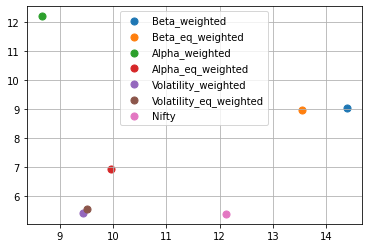

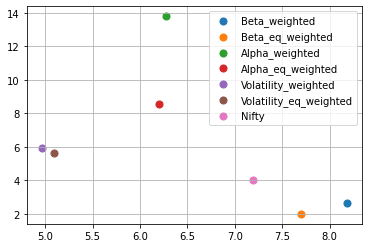

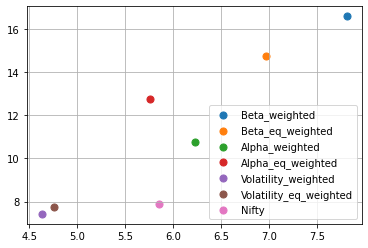

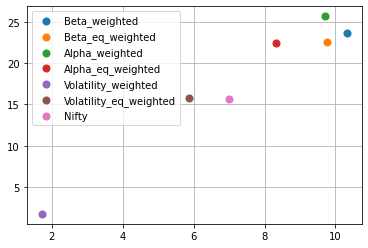

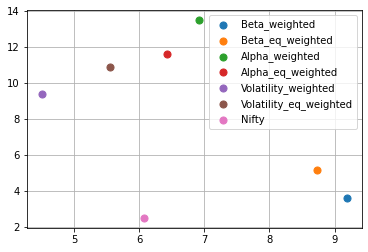

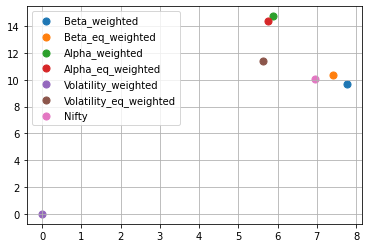

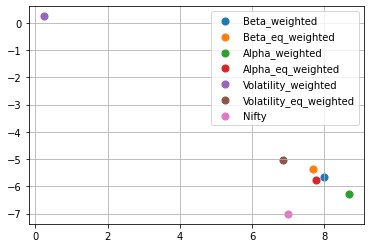

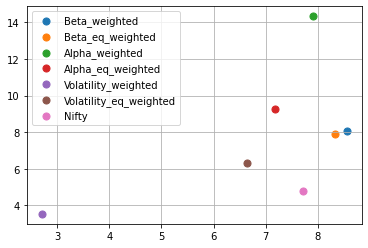

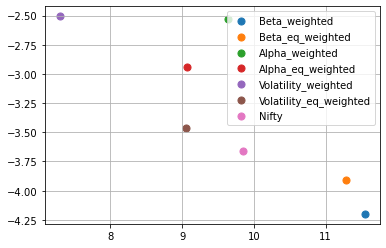

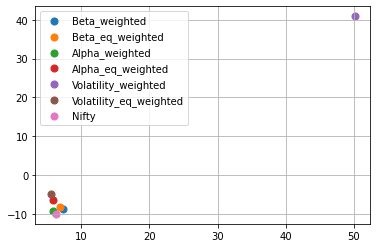

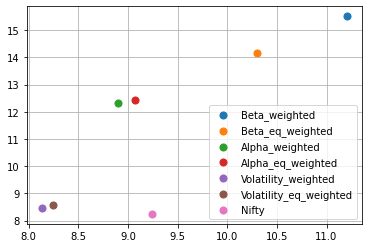

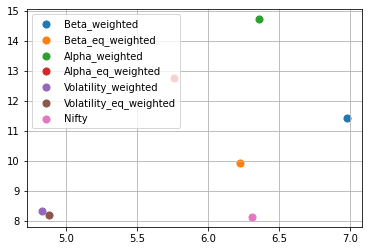

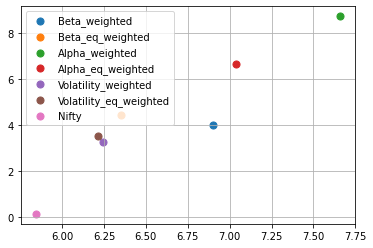

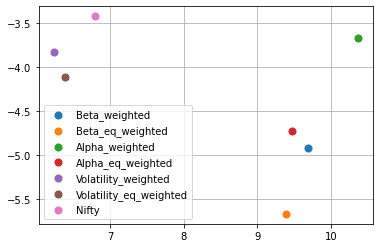

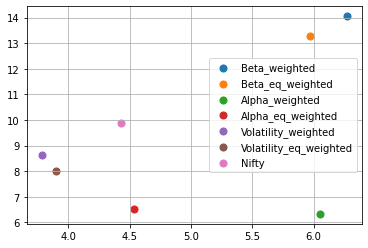

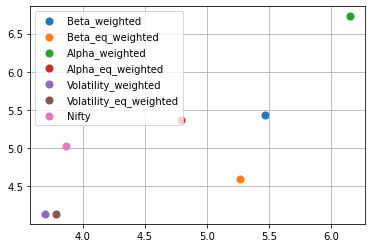

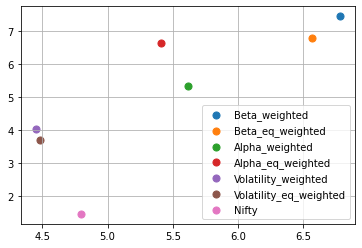

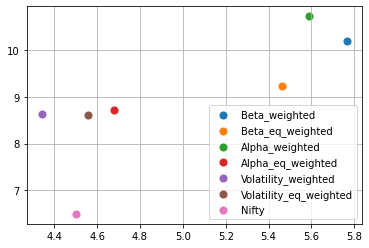

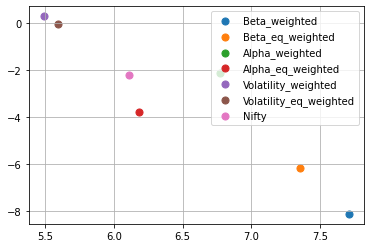

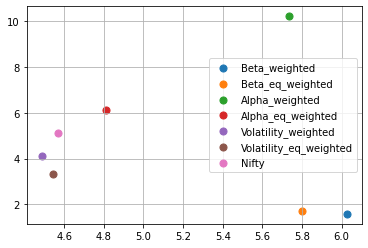

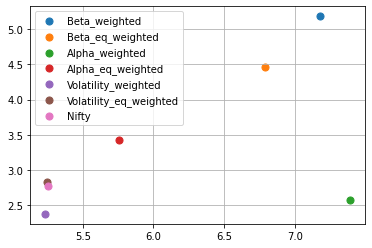

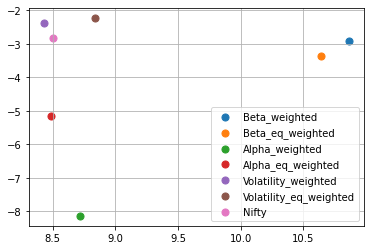

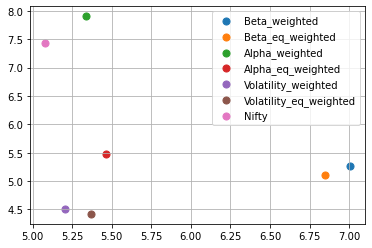

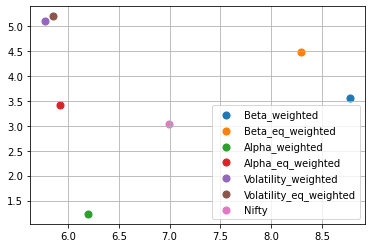

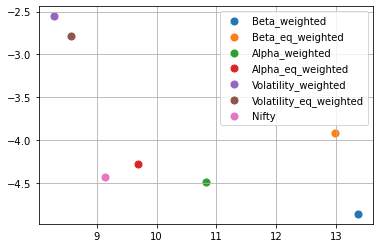

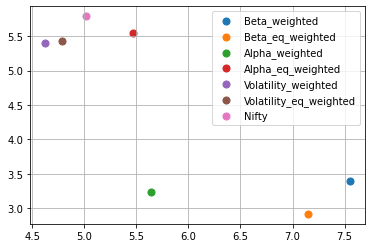

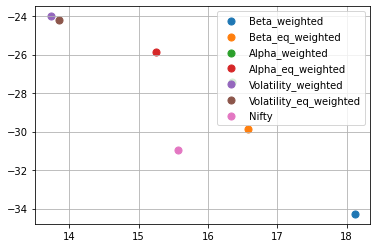

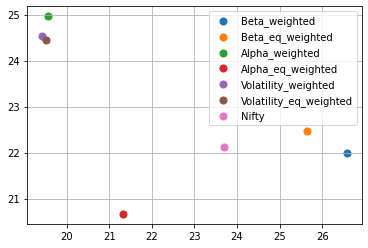

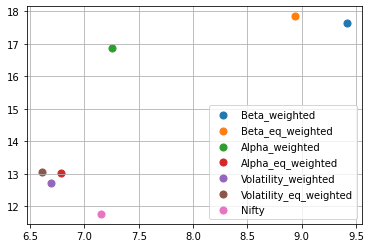

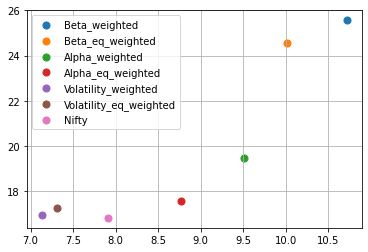

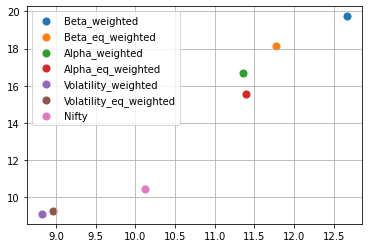

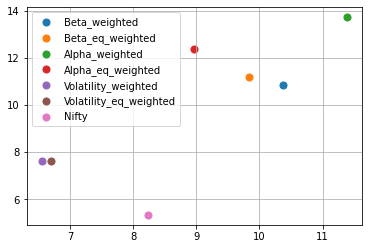

In [12]:
p, f=final(df,60,n_stocks)

In [13]:
def cum_ret(x):
    y=100
    for i in x:
        y=y*(1+(i/100))
    return round(y,2)
a=pd.DataFrame(f[0], columns=p)
p=a.columns
a=a.apply(lambda x: cum_ret(x))

In [14]:
a

Beta_weighted             476.55
Beta_eq_weighted          483.98
Alpha_weighted            720.08
Alpha_eq_weighted         546.42
Volatility_weighted       489.59
Volatility_eq_weighted    404.20
Nifty                     270.72
dtype: float64

In [15]:
b=np.mean(pd.DataFrame(f[1],columns=p))

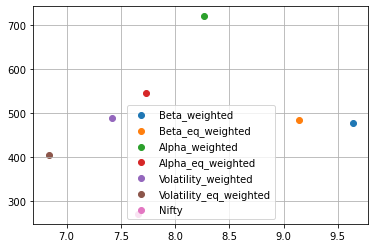

In [16]:
#plt.figure(figsize=(10,10))
for i in p:
    plt.scatter(b[i],a[i])
plt.grid()
plt.legend(p)